# Climate Analysis
### Description

In [1]:
## Dependencies
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
## Plot Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
plt.style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Convert string to datetime object
last_date = dt.datetime.strptime(last_date[0], "%Y-%m-%d").date()
# Print date
print(f"Most recent date in dataset: {last_date}")

Most recent date in dataset: 2017-08-23


In [13]:
# Calculate the date one year from the last date in data set
minus_one_year = last_date - relativedelta(years=1)
# Print date
print(f"One year from last date: {minus_one_year}")

One year from last date: 2016-08-23


In [14]:
## Define query to retrieve last 12 months of precipitation data
stmt = session.query(Measurement.date, Measurement.prcp.label('precipitation')).filter(Measurement.date >= func.strftime(minus_one_year)).statement

## Store query results into DataFrame & Set index (date column)
precipitation_df = pd.read_sql_query(stmt, session.bind, index_col='date')

## Drop missing values
precipitation_df.dropna(inplace=True)

## Sort DataFrame by date
precipitation_df.sort_index(ascending=True, inplace=True)

## Display DataFrame (preview)
precipitation_df.head(7)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22


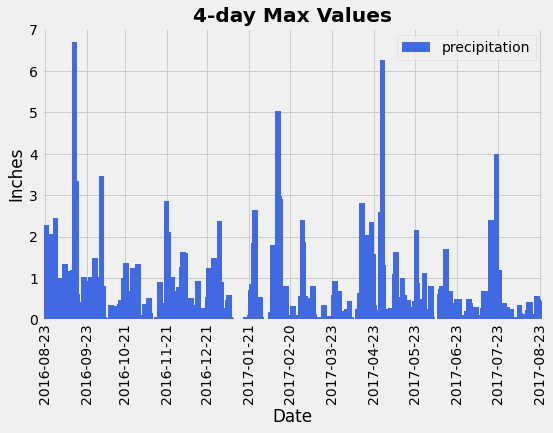

In [15]:
# Plot results using DataFrame.plot()
precipitation_df.groupby(precipitation_df.index).max().plot(
    kind='bar', figsize=(8,5), color='royalblue', width=4, rot=90)

## Set plot title & labels
plt.title('4-day Max Values', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Inches')

## Set x-tickers (by month)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))

## Save plot
plt.savefig('Images/Precipitation.png', bbox_inches='tight')

## Display plot
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Measurement.station.distinct())).all()

[(9,)]

In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
slct = [Measurement.station, func.count(Measurement.station)]

session.query(*slct).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = 'USC00519281'

slct = [Measurement.station,
          func.min(Measurement.tobs),
          func.max(Measurement.tobs),
          func.avg(Measurement.tobs)]

session.query(*slct).\
    filter(Measurement.station == most_active).\
    group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

## Define query to retrieve last 12 months of precipitation data
slct = [Measurement.date, Measurement.tobs.label('temperature')]

stmt = session.query(*slct).\
    filter(Measurement.date >= func.strftime(minus_one_year)).\
    filter(Measurement.station == most_active).statement

## Store query results into DataFrame & set the index (date column)
temperature_df = pd.read_sql_query(stmt, session.bind, index_col='date')

## Display DataFrame (preview)
temperature_df.head(7)

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0


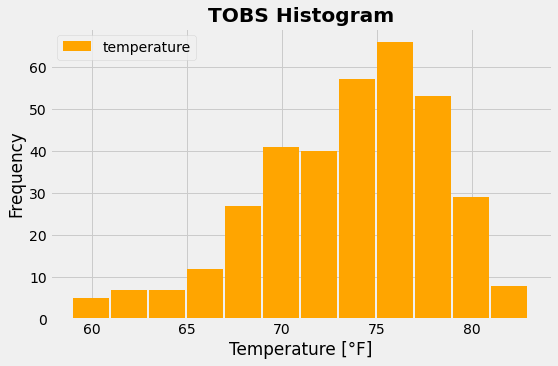

In [21]:
## Set parameters
x = temperature_df['temperature'].values
label = temperature_df['temperature'].name
bins = 12

## Set figure size
plt.figure(figsize=(8,5))

## Plot histogram
n, bins, patches = plt.hist(x, bins=bins, color='orange', label=label, width=1.9)

## Set plot title and labels
plt.title('TOBS Histogram', fontweight="bold")
plt.xlabel('Temperature [°F]')
plt.ylabel('Frequency')

## Set legend
plt.legend()

## Save plot
plt.savefig('Images/Histogram.png', bbox_inches='tight')

## Display plot
plt.show()

# Close session

In [22]:
# Close Session
session.close()